In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Sum"): return "GAT:Sum"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Max"): return "GAT:Max"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Mean"): return "GAT:Mean"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Sum"): return "GIN:Sum"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Max"): return "GIN:Max"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Mean"): return "GIN:Mean"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Sum"): return "GCN:Sum"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Max"): return "GCN:Max"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Mean"): return "GCN:Mean"
    elif  isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df.to_csv("project.csv")

In [32]:
run_overview = runs_df.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values='test_accuracy' ,aggfunc=lambda x: len(x))
print(f'Number of runs: {runs_df.shape[0]}')
run_overview

Number of runs: 3439


dataset                    Alchemy10K  ENZYMES  IMDB-BINARY  NCI1  PROTEINS
model_type pool_type                                                       
1-WL+NN    Embedding:Max          NaN    183.0        275.0  43.0     179.0
           Embedding:Mean         NaN    141.0        263.0  69.0     167.0
           Embedding:Sum        273.0    134.0        286.0  51.0     156.0
           Max                    NaN     86.0         49.0  26.0      35.0
           Mean                   NaN     76.0         47.0  19.0      27.0
           Sum                    NaN     85.0         45.0  14.0      29.0
GNN        GAT:Max                NaN     17.0         17.0  11.0      10.0
           GAT:Mean               NaN     28.0         15.0  12.0      10.0
           GAT:Sum                NaN     25.0         17.0  15.0      16.0
           GCN:Max                NaN     31.0         22.0  17.0      10.0
           GCN:Mean               NaN     19.0         25.0  19.0      16.0
           GCN:Sum                NaN     30.0         29.0  17.0      14.0
           GIN:Max                NaN     21.0         17.0  25.0      20.0
           GIN:Mean               NaN     31.0          9.0  18.0      26.0
           GIN:Sum                NaN     26.0          9.0  20.0      11.0

In [6]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std'):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):
        best_idx = grouping_df[acc_col].idxmax()
        
        if math.isnan(best_idx):
            continue
        
        acc = grouping_df.loc[best_idx, acc_col]
        std = grouping_df.loc[best_idx, std_col]
        result = f"{acc:.2f} \u00B1 {std:.1f}"
        #result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                     {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [7]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std')
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                                       
dataset                         ENZYMES  IMDB-BINARY         NCI1     PROTEINS
model_type pool_type                                                          
1-WL+NN    Embedding:Max    40.50 ± 7.4  69.38 ± 4.9  82.74 ± 2.0  75.20 ± 3.9
           Embedding:Mean   42.60 ± 9.0  72.40 ± 4.1  83.10 ± 1.9  72.68 ± 4.6
           Embedding:Sum    48.27 ± 8.1  72.00 ± 3.8  83.60 ± 2.2  75.18 ± 4.5
           Max              16.70 ± 4.2  51.98 ± 5.3  58.55 ± 3.3  62.90 ± 4.9
           Mean             18.17 ± 4.8  59.12 ± 6.2  64.03 ± 3.3  60.95 ± 4.5
           Sum              18.03 ± 6.2  57.48 ± 5.1  56.95 ± 3.8  65.58 ± 4.8
GNN        GAT:Max          31.20 ± 6.0  70.72 ± 4.8  58.01 ± 4.2  72.54 ± 5.1
           GAT:Mean         28.93 ± 5.9  70.94 ± 3.7  66.09 ± 2.8  64.92 ± 6.4
           GAT:Sum          34.40 ± 7.0  72.20 ± 4.5  69.82 ± 2.6  73.43 ± 3.9
           GCN:Max          33.07 ± 7.5  73.52 ± 4.1  61.06 ± 3.6  69.79 ± 5.9
           GCN:Mean         29.87 ± 5.7  74.68 ± 3.8  68.93 ± 2.4  70.92 ± 5.2
           GCN:Sum          31.73 ± 7.2  73.02 ± 4.4  70.38 ± 2.1  73.89 ± 4.0
           GIN:Max          29.20 ± 6.2  70.80 ± 4.7  79.86 ± 2.2  74.28 ± 5.1
           GIN:Mean         31.73 ± 6.7  71.10 ± 5.4  71.30 ± 2.2  71.96 ± 4.0
           GIN:Sum          28.90 ± 8.7  69.46 ± 4.8  70.84 ± 2.3  73.20 ± 4.3

In [7]:
latex_table.to_latex("table.tex", escape=True, multirow=True, multicolumn=True, multicolumn_format='c', bold_rows=False)

In [8]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std')
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_lin_accuracies'], aggfunc=lambda x: x)
latex_svm

svm_lin_accuracies                            \
dataset                              ENZYMES  IMDB-BINARY         NCI1   
model_type pool_type                                                     
1-WL+NN    Embedding:Max         36.93 ± 5.6  68.94 ± 4.8  82.91 ± 1.9   
           Embedding:Mean        37.37 ± 6.6  71.24 ± 3.9  82.71 ± 1.8   
           Embedding:Sum         34.37 ± 5.5          NaN  83.42 ± 2.1   
GNN        GCN:Max               37.30 ± 6.9  73.52 ± 4.3          NaN   
           GCN:Mean                      NaN  73.88 ± 4.2          NaN   
           GCN:Sum                       NaN  74.30 ± 4.4          NaN   
           GIN:Max                       NaN          NaN  67.42 ± 2.2   
           GIN:Mean              29.00 ± 6.2          NaN  69.21 ± 2.2   
           GIN:Sum                       NaN          NaN  70.12 ± 3.1   

                                        
dataset                       PROTEINS  
model_type pool_type                    
1-WL+NN    Embedding:Max   73.92 ± 4.1  
           Embedding:Mean  66.88 ± 4.2  
           Embedding:Sum   74.53 ± 4.0  
GNN        GCN:Max                 NaN  
           GCN:Mean                NaN  
           GCN:Sum         73.85 ± 4.2  
           GIN:Max         74.73 ± 4.2  
           GIN:Mean        67.74 ± 4.4  
           GIN:Sum                 NaN

In [11]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std')
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies                            \
dataset                              ENZYMES  IMDB-BINARY         NCI1   
model_type pool_type                                                     
1-WL+NN    Embedding:Max         41.23 ± 5.8  69.22 ± 5.0  83.08 ± 2.0   
           Embedding:Mean        43.40 ± 7.0  72.76 ± 4.3  83.41 ± 1.9   
           Embedding:Sum         44.97 ± 7.0          NaN  83.61 ± 1.9   
GNN        GCN:Max               28.50 ± 5.7  72.98 ± 4.2          NaN   
           GCN:Mean                      NaN  74.14 ± 3.9          NaN   
           GCN:Sum                       NaN  73.60 ± 4.1          NaN   
           GIN:Max                       NaN          NaN  72.98 ± 1.9   
           GIN:Mean              29.43 ± 5.9          NaN  70.25 ± 2.0   
           GIN:Sum                       NaN          NaN  70.90 ± 2.3   

                                        
dataset                       PROTEINS  
model_type pool_type                    
1-WL+NN    Embedding:Max   75.22 ± 4.0  
           Embedding:Mean  73.65 ± 4.6  
           Embedding:Sum   74.48 ± 3.8  
GNN        GCN:Max                 NaN  
           GCN:Mean                NaN  
           GCN:Sum         73.29 ± 4.6  
           GIN:Max         74.62 ± 4.6  
           GIN:Mean        71.50 ± 4.2  
           GIN:Sum                 NaN

In [10]:
latex_table

test_accuracy                              \
dataset                         ENZYMES   IMDB-BINARY          NCI1   
model_type pool_type                                                  
1-WL+NN    Embedding:Max   40.50 ± 7.36  69.38 ± 4.90  82.59 ± 1.88   
           Embedding:Mean  42.60 ± 9.02  72.40 ± 4.06  82.92 ± 2.03   
           Embedding:Sum   48.27 ± 8.11  72.00 ± 3.84  83.60 ± 2.18   
           Max                      NaN  51.62 ± 5.01  58.55 ± 3.27   
           Mean                     NaN  58.46 ± 6.59  63.97 ± 3.23   
           Sum             17.27 ± 4.63  56.12 ± 6.12  54.49 ± 3.24   
GNN        Max             33.07 ± 7.46  73.52 ± 4.10  79.63 ± 2.24   
           Mean            31.73 ± 6.70  74.68 ± 3.84  70.76 ± 2.16   
           Sum             34.40 ± 7.00  72.90 ± 3.83  70.84 ± 2.32   

                                         
dataset                        PROTEINS  
model_type pool_type                     
1-WL+NN    Embedding:Max   75.20 ± 3.92  
           Embedding:Mean  72.32 ± 4.19  
           Embedding:Sum   75.18 ± 4.46  
           Max             62.90 ± 4.93  
           Mean            60.89 ± 4.69  
           Sum             65.44 ± 4.80  
GNN        Max             74.28 ± 5.07  
           Mean            71.96 ± 4.04  
           Sum             73.45 ± 3.92

In [11]:
latex_svm

svm_lin_accuracies              
dataset                              ENZYMES   IMDB-BINARY
model_type pool_type                                      
1-WL+NN    Embedding:Max        36.93 ± 5.65  68.94 ± 4.78
           Embedding:Mean       37.37 ± 6.60  71.24 ± 3.93
           Embedding:Sum        34.37 ± 5.47           NaN
GNN        Max                  37.30 ± 6.91           NaN
           Mean                 29.00 ± 6.22           NaN

In [11]:
model = torch.load('saved_models/GIN:Max: 15.06.2023 10:09:01.pt')

dataset = model.dataset
train_index, test_index = model.train_index, model.test_index
agg_data = model.data_aggregate
proccesed_data = model.gnn(dataset.x, dataset.edge_index)

In [32]:
from utils import Wrapper_WL_TUDataset

wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=1, wl_convergence=False)

In [36]:
# Sample 10 random graphs from the test set
indices_graphs = torch.randint(0, len(test_index), (10,))
indices_graphs = test_index[indices_graphs]

global_error_mean = 0.0
global_error_std = 0.0
df_dist_matrix = pd.DataFrame()
df_tsne = pd.DataFrame()

with torch.no_grad():
    for idx in test_index:
        num_nodes = dataset[idx].num_nodes
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        # Calculate distance matrix
        distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
        distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn
        distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)

        dist_data = pd.DataFrame(list(itertools.product(['GNN Node Representations', '1-WL Colors'], range(0, num_nodes), range(0, num_nodes))), columns=['type', 'i', 'j'])
        dist_data['distance'] = torch.cat([distance_matrix_gnn.flatten(), distance_matrix_wl.flatten()], dim=0).numpy()
        dist_data['idx'] = idx.item()

        error_matrix = (distance_matrix_gnn - distance_matrix_wl).abs()
        dist_data['normed_error'] = f"MAE: {round(error_matrix.mean().item(), 2)} ± {round(error_matrix.std().item(), 2)}"
        global_error_mean += error_matrix.mean().item()
        global_error_std += error_matrix.std().item()


        df_dist_matrix = pd.concat([df_dist_matrix, dist_data], axis=0, ignore_index=True)

        if idx in indices_graphs:
            pass
            # # Calculate t-SNE
            # x_tsne = TSNE(n_components=2, perplexity=len(x_gnn)-1).fit_transform(x_gnn)
            # data_tsne = pd.DataFrame(x_tsne, columns=['x', 'y'])
            # data_tsne['color'] = x_wl.numpy()
            # data_tsne['idx'] = idx.item()

            # df_tsne = pd.concat([df_tsne, data_tsne], axis=0, ignore_index=True)

print(f'Global normed error: {round(global_error_mean / len(test_index), 2)} ± {round(global_error_std / len(test_index), 2)}')

Global normed error: 0.49 ± 0.26


In [22]:
indices_graphs

array([217, 904, 910, 419, 795, 319, 786, 287, 864, 702])

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


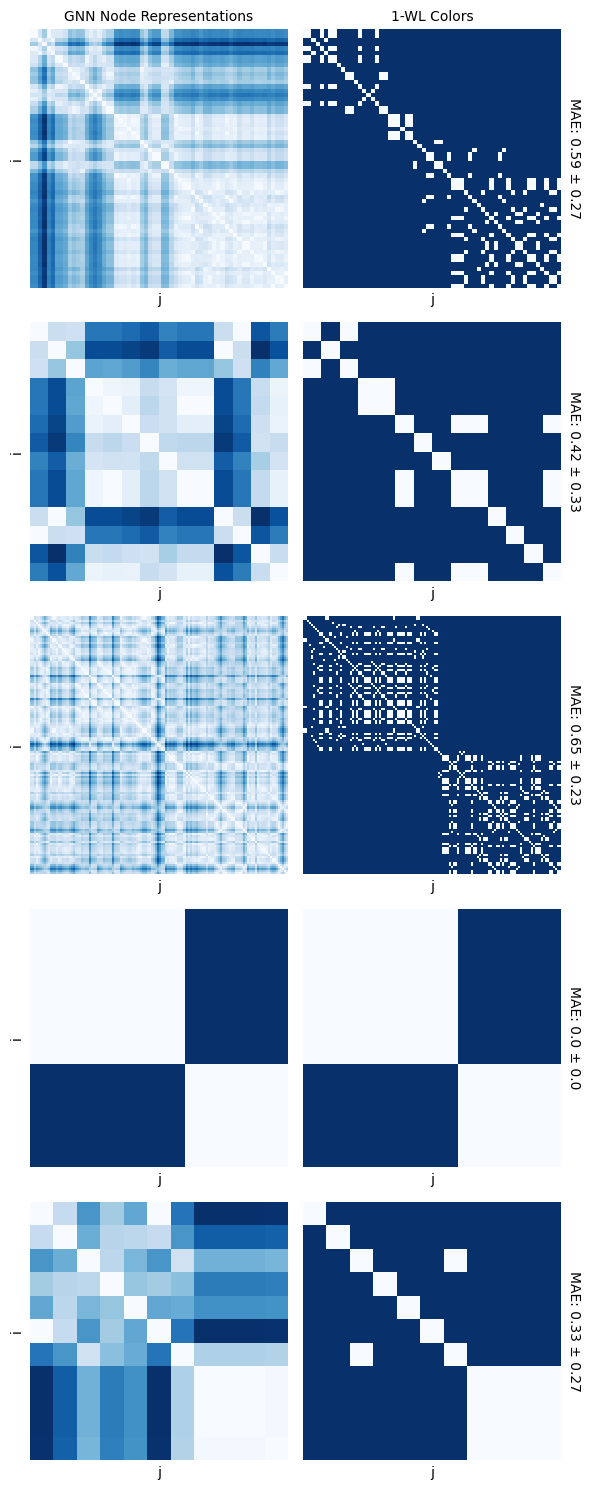

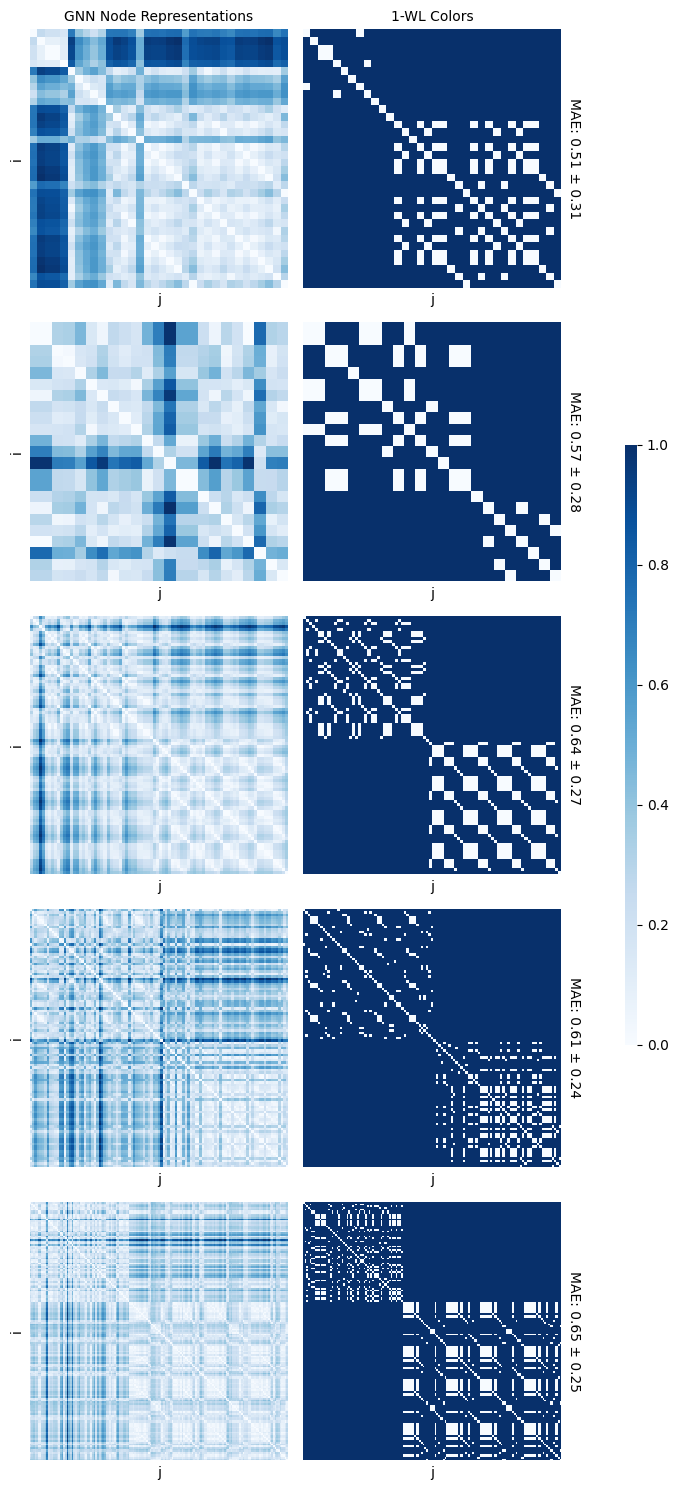

In [37]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    

    #g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.pdf'.format(i), bbox_inches='tight')

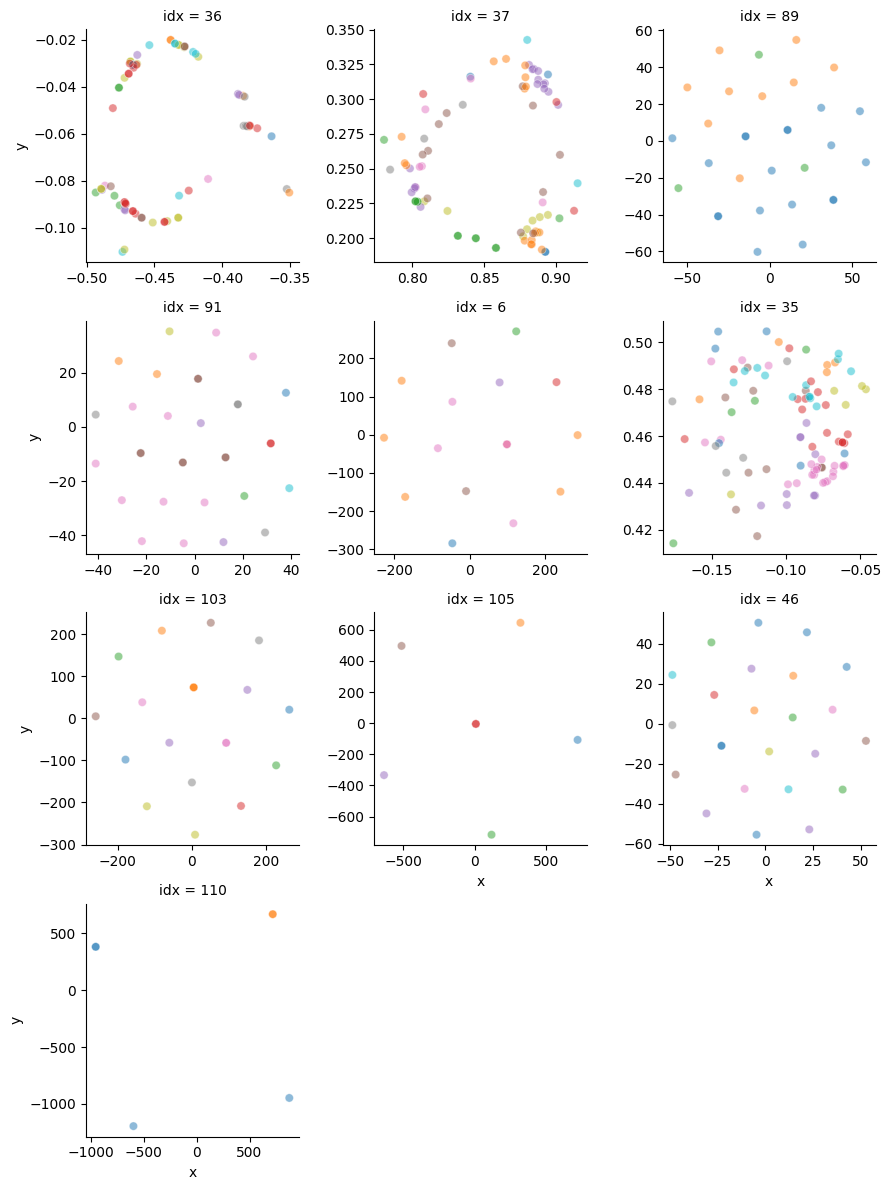

In [54]:
g = sns.FacetGrid(data=df_tsne, col='idx', col_wrap=3, sharex=False, sharey=False)
g.map(sns.scatterplot, 'x', 'y', 'color', alpha=0.5, palette='tab10')

In [1]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [9]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [19]:
df_cluster_metrics

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name,num_cluster
0,0.966394,0.297932,0.687398,0.613401,0.780458,0.614167,0.687398,0.367233,kmeans,149
1,0.966792,0.292508,0.710801,0.640931,0.812982,0.631438,0.710801,0.369268,aggC_ward,149
2,0.948761,0.340135,0.653657,0.592979,0.655570,0.651755,0.653657,0.367724,aggC_avg,149
3,0.209294,0.014530,0.146240,0.130254,0.080907,0.759746,0.146240,0.208999,dbscan,149
4,0.635521,-0.000065,0.423289,0.258958,0.374406,0.486854,0.423289,0.114880,optics,149
5,0.955879,0.296869,0.617139,0.546602,0.641659,0.594424,0.617139,0.322979,birch,149
6,0.964425,0.242018,0.651642,0.568485,0.743872,0.579759,0.651642,0.308943,bisectingKmeans,149
